In [2]:

# Import packages
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Set options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

train_x_raw = pd.read_csv("../01-Data/X_train.csv", low_memory = True, index_col=0)
train_y_raw = pd.read_csv("../01-Data/y_train.csv", low_memory = True, index_col=0)
test_x_raw = pd.read_csv("../01-Data/X_test.csv", low_memory=True, index_col=0)

df_train = pd.DataFrame(train_x_raw)
df_test = pd.DataFrame(test_x_raw)
df_y = pd.DataFrame(train_y_raw)

FileNotFoundError: [Errno 2] No such file or directory: '../01_Data/X_train.csv'

Add all of the preprocessing below

## Variable 1 - 146 Preprocessing

In [116]:
columns_to_drop = ['c_abrv', 'f46_IT', 'v72_DE', 'v73_DE', 'v74_DE', 'v75_DE', 'v76_DE', 'v77_DE', 'v78_DE', 'v79_DE']
df_train.drop(columns=columns_to_drop, inplace=True)
df_test.drop(columns=columns_to_drop, inplace=True)

## Variable 147 - 292 Preprocessing 

In [117]:
### Function to find the targeted colname
def find_colname(data, target):
    temp = []
    for varname in data.columns:
        if varname.endswith(target):
            temp.append(varname)
    return(temp)

merge_colname = find_colname(train_x_raw, '_11c')
print(find_colname(train_x_raw, 'c'))
print(find_colname(train_x_raw, '_r'))

def merge_columns(dat, colname):
    for name in colname:
        name_org = name.replace("_11c", "")
        dat.loc[dat[name_org] == -4, name_org] = dat.loc[dat[name_org] == -4, name]

['v30c', 'v45c', 'v133_11c', 'v134_11c', 'v135_11c', 'v136_11c', 'v137_11c', 'v138_11c', 'v139_11c', 'v140_11c', 'v141_11c']
['age_r', 'v228b_r', 'v231b_r', 'v233b_r', 'v239_r', 'v242_r', 'v243_r', 'v251b_r', 'v252_r', 'v261_r', 'v262_r', 'v263_r', 'v276_r', 'v278c_r', 'v279c_r', 'v279d_r', 'v281a_r']


## Variable 293 - 438 Preprocessing

In [118]:
## removed string type data
df_train.drop('v228b', inplace=True, axis=1) 
df_test.drop('v228b', inplace=True, axis=1) 

df_train.fillna({'v228b_r': -3}, inplace=True)
df_test.fillna({'v228b_r': -3}, inplace=True)

df_train.drop('v231b', inplace=True, axis=1) 
df_test.drop('v231b', inplace=True, axis=1)

df_train.fillna({'v231b_r': -3}, inplace=True)
df_test.fillna({'v231b_r': -3}, inplace=True)

df_train.drop('v233b', inplace=True, axis=1)
df_test.drop('v233b', inplace=True, axis=1)

df_train.fillna({'v233b_r': -3}, inplace=True)
df_test.fillna({'v233b_r': -3}, inplace=True)

df_train.drop('v251b', inplace=True, axis=1)
df_test.drop('v251b', inplace=True, axis=1) 

df_train.fillna({'v251b_r': -3}, inplace=True)
df_test.fillna({'v251b_r': -3}, inplace=True)

df_train.drop('f252_edulvlb_CH', inplace=True, axis=1)
df_test.drop('f252_edulvlb_CH', inplace=True, axis=1)

## removed the column having 'DE'
df_train.drop(list(df_train.filter(regex='DE')), axis=1, inplace=True)
df_test.drop(list(df_test.filter(regex='DE')), axis=1, inplace=True)

## removed the column having 'GB'
df_train.drop(list(df_train.filter(regex='GB')), axis=1, inplace=True)
df_test.drop(list(df_test.filter(regex='GB')), axis=1, inplace=True)

df_train.drop('v281a', inplace=True, axis=1)
df_test.drop('v281a', inplace=True, axis=1)

# Simple Model Run

In [119]:
# Prepare the DMatrix 
# Convert to 'category' type
# Make sure the conversion is applied to df_train and df_test if they are used for DMatrix
df_train['v275b_N2'] = df_train['v275b_N2'].astype('category')
df_train['v275b_N1'] = df_train['v275b_N1'].astype('category')
df_test['v275b_N2'] = df_test['v275b_N2'].astype('category')
df_test['v275b_N1'] = df_test['v275b_N1'].astype('category')

label_mapping = {-1: 0, 1: 1, 2: 2, 3: 3, 4: 4}
df_y = df_y.replace(label_mapping)
# When creating DMatrix, enable categorical support
dtrain = xgb.DMatrix(df_train, label=df_y, enable_categorical=True)
dtest = xgb.DMatrix(df_test, enable_categorical=True)

# Set XGBoost parameters 
params = {
    'max_depth': 6,
    'eta': 0.01,
    'objective': 'multi:softprob',
    'num_class': 5,  # We have 5 classes: 0, 1, 2, 3, 4
    'eval_metric': 'mlogloss',
}
num_boost_round = 400  # Number of boosting rounds

bst = xgb.train(params, dtrain, num_boost_round)
y_test_probs = bst.predict(dtest)

class_order = [0, 1, 2, 3, 4]
class_mapping = {class_label: f"Class_{class_label}" for class_label in class_order}

submission_df = pd.DataFrame(y_test_probs, columns=class_mapping.values())
submission_df.columns = ['no answer', 'very important', 'quite important', 'not important', 'not at all important']
submission_df.insert(0, 'id', df_test.index)

# Save the submission file
# submission_file = 'submission.csv'
submission_file = 'submission.xlsx'
## submission_df.to_csv(submission_file,lineterminator=None, index=False)
with pd.ExcelWriter(submission_file) as writer:
    submission_df.to_excel(writer, sheet_name="Sheet1") 


In [120]:
# Neural Network
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [46]:
pd.crosstab(index=df_train['v275b_N2'], columns='count')

col_0,count
v275b_N2,
-1,17
-4,1817
AL01,345
AL02,443
AL03,406
AM01,472
AM02,313
AM03,242
AM04,230


In [141]:
label_mapping = {-1: 0, 1: 1, 2: 2, 3: 3, 4: 4}
df_y = df_y.replace(label_mapping)

df_train.drop('v275b_N2', inplace=True, axis=1)
df_test.drop('v275b_N2', inplace=True, axis=1)

df_train.drop('v275b_N1', inplace=True, axis=1)
df_test.drop('v275b_N1', inplace=True, axis=1) 

In [142]:
df_z_scaled = df_train.copy()
df_tz = df_test.copy()
print(len(df_z_scaled.columns))
# apply normalization techniques 
for column in df_z_scaled.columns:
    df_z_scaled[column] = df_z_scaled[column].astype(float)
    df_z_scaled[column] = (df_z_scaled[column] -
                           df_z_scaled[column].min()) / (df_z_scaled[column].max()- df_z_scaled[column].min())
df_z_scaled_ts = torch.tensor(df_z_scaled.values, dtype=torch.float32)
for column in df_tz.columns:
    df_tz[column] = df_tz[column].astype(float)
    df_tz[column] = (df_tz[column] -
                           df_tz[column].min()) / (df_tz[column].max()- df_tz[column].min())
df_tz = torch.tensor(df_tz.values, dtype=torch.float32)
df_t = torch.tensor(df_y['label'].values, dtype=torch.int64)
df_z_scaled_ts = torch.nan_to_num(df_z_scaled_ts)
df_tz = torch.nan_to_num(df_tz)

399


In [143]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, n=300):
        super().__init__()
        self.x = df_z_scaled_ts
        self.t = df_t
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.t[idx]
    
    def inputs(self):
        return self.x
    
    def targets(self):
        return self.t
    

In [144]:
class datasett(torch.utils.data.Dataset):
    def __init__(self, n=300):
        super().__init__()
        self.x = df_tz
        self.t = df_t
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.t[idx]
    
    def inputs(self):
        return self.x
    
    def targets(self):
        return self.t
    

In [154]:
# Batched, for training
batch_size_train = 256
train_dl = torch.utils.data.DataLoader(dataset(), batch_size=batch_size_train, shuffle=True)
train_all = torch.utils.data.DataLoader(dataset(), batch_size=59438, shuffle=True)
test_all = torch.utils.data.DataLoader(datasett(), batch_size=48000, shuffle=True)

In [161]:
class ClassifierNN(nn.Module):
    '''
     
    '''
    def __init__(self):
        self.losses = []
        super().__init__()
        
        #===== YOUR CODE HERE =====
        self.seq= nn.Sequential(
            nn.Linear(399, 512),
            nn.Sigmoid(),
            nn.Linear(512, 128),
            nn.Sigmoid(),
            nn.Linear(128, 32),
            nn.Sigmoid(),
            nn.Linear(32, 5),
            nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        #===== YOUR CODE HERE =====
        x = self.seq(x)
        return x  # replace this line

In [162]:

print(df_z_scaled_ts)
display(df_train)
print(df_z_scaled.shape)
print(df_t)
print(df_t.shape)
print(df_tz)
print(max(df_z_scaled_ts[0]))
print(torch.max(df_z_scaled_ts[0]))
print(torch.min(df_z_scaled_ts))
print(torch.min(df_z_scaled_ts))
print(torch.mean(df_z_scaled_ts[0]))

df_z_scaled_ts = torch.nan_to_num(df_z_scaled_ts)
df_z_scaled_ts

tensor([[7.5000e-01, 7.6441e-01, 7.5250e-01,  ..., 7.1429e-01, 7.9236e-01,
         3.8948e-07],
        [2.5000e-01, 2.5815e-01, 2.5250e-01,  ..., 8.5714e-01, 6.6279e-01,
         7.5732e-08],
        [0.0000e+00, 0.0000e+00, 2.3250e-01,  ..., 8.5714e-01, 1.2292e-01,
         9.8451e-07],
        ...,
        [2.5000e-01, 2.4060e-01, 2.4250e-01,  ..., 7.1429e-01, 2.4917e-02,
         1.5146e-07],
        [0.0000e+00, 7.5188e-03, 2.2750e-01,  ..., 0.0000e+00, 5.6478e-02,
         0.0000e+00],
        [2.5000e-01, 2.4060e-01, 2.4250e-01,  ..., 7.1429e-01, 2.1595e-01,
         8.4679e-05]])


,year,fw_start,fw_end,country,v1,v2,v3,v4,v5,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,f20,v20,v20a,v20b,v21,v22,v23,v24,f24_IT,v24a_IT,v24b_IT,v25,v26,v27,v28,v29,v30,f30a,v30a,v30b,v30c,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,f45a,v45a,v45b,v45c,v46,v47,v48,v49,v50,v51,v52,v52_cs,v53,v54,v55,v56,v57,v58,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v80,v81,v82,v83,v84,f85,v85,v86,v87,v88,v89,v90,v91,v92,v93,v94,v95,f96,v96,v96a,v96b,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,f108,v108,v109,f110,v110,v111,v111_4,v112,f112_SE,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131,v132,v133,v133_11c,v134,v134_11c,v135,v135_11c,v136,v136_11c,v137,v137_11c,v138,v138_11c,v139,v139_11c,v140,v140_11c,v141,v141_11c,v142,v143,v144,v145,v146,v147,v148,v149,v150,v151,v152,v153,v154,v155,v156,v157,v158,v159,v160,v161,v162,v163,v164,v165,v166,v167,v168,v169,v170,v171,v172,v173,v174_LR,v174_cs,v175_LR,v175_cs,v176,v176_DK,v177,v177_DK,v178,v178_DK,v179,v179_DK,v180,v180_DK,v181,v181_DK,v182,v182_DK,v183,v183_DK,v184,v185,v186,v187,v188,v189,v190,v191,v192,v193,v194,v195,v196,v197,v198,v199,v200,v201,v202,v203,v204,v205,v206,v207,v208,v209,v210,v211,v212,v213,v214,v215,v216,v217,v218,v219,v220,v221,v221_DK,v222,v222_DK,v223,v223_DK,v224,v224_DK,v225,v226,age,age_r,age_r2,age_r3,v227,v228b_r,v229,v230,v231b_r,v232,v233b_r,v234,v235,v236,v237,v238,v239_r,v239a,v239b,v240,v241,v242,v242_r,v243_edulvlb,v243_edulvlb_2,v243_edulvlb_1,v243_ISCED_3,v243_ISCED_2,v243_ISCED_2b,v243_ISCED_1,v243_EISCED,v243_ISCED97,v243_8cat,v243_r,v243_cs,v244,v245,v246_ISCO_2,v246_SIOPS,v246_ISEI,v246_ESeC,v246_egp,v247,v248,v248a,v249,v250,v251b_r,v252_edulvlb,v252_edulvlb_2,v252_edulvlb_1,v252_ISCED_3,v252_ISCED_2,v252_ISCED_2b,v252_ISCED_1,v252_EISCED,v252_ISCED97,v252_8cat,v252_r,v252_cs,v253,v254,v255_ISCO_2,v255_SIOPS,v255_ISEI,v255_ESeC,v255_egp,v256,v257,v258,v259,v260,v261,v261_ppp,v261_r,v262_edulvlb,v262_edulvlb_2,v262_edulvlb_1,v262_ISCED_3,v262_ISCED_2,v262_ISCED_2b,v262_ISCED_1,v262_EISCED,v262_ISCED97,v262_8cat,v262_r,v262_cs,v263_edulvlb,v263_edulvlb_2,v263_edulvlb_1,v263_ISCED_3,v263_ISCED_2,v263_ISCED_2b,v263_ISCED_1,v263_EISCED,v263_ISCED97,v263_8cat,v263_r,v263_cs,v264,v265,v266,v267,v268,v269,v270,v271,v272,v273,v274,v275c_N2,v275c_N1,v276_r,v277,v278a,v278b,v278c_r,v279a,v279b,v279c_r,v279d_r,v280,v281a_r,v282
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2020,202011,202011,804,2,1,2,2,3,2,3,1,2,1,2,2,2,2,2,2,2,2,0,2,2,2,1,2,1,2,-4,-4,-4,1,1,2,2,2,1,-4,-4,-4,-4,2,1,2,2,3,2,2,5,5,1,1,2,1,1,1,0,2,-4,-4,1,2,2,3,3,1,1,80403,-3,2,2,1,1,1,1,1,1,1,9,1,1,2,2,2,1,2,2,2,2,2,2,2,3,2,2,1,2,4,3,2,0,2,1,1,2,2,1,2,1,1,2,2,0,2,-4,-4,3,2,2,2,3,-2,3,8,3,5,5,0,2,1,0,4,2,3,1,-4,3,3,1,1,2,2,3,3,4,3,3,3,3,3,4,3,3,3,3,3,7,-4,0,-4,10,-4,9,-4,0,-4,10,-4,5,-4,0,-4,10,-4,10,5,1,4,3,4,1,2,2,1,2,1,4,4,5,1,5,2,1,5,1,3,1,1,1,1,1,1,2,1,1,-4,5,80403,8,80411,1,-4,3,-4,2,-4,3,-4,2,-4,1,-4,3,-4,4,-4,3,5,3,3,5,3,1,1,1,1,3,2,3,1,3,2,4,4,4,4,1,2,4,4,2,1,4,5,3,3,3,4,4,2,2,5,2,2,-4,2,-4,1,-4,1,-4,1,1960,60,5,3,5,1,-3.0,-3,1,-3.0,1,-3.0,1,2,-3,-3,1,0,0,0,2,58,19,8,323,32,3,354,35,34,3,4,3,6,2,80404,5,1,92,21,11,9,10,-3,2,-3,2,1,-3.0,423,42,4,454,45,44,4,4,4,6,2,80407,9,1,21,62,80,1,1,-3,1,1,2,2,2,1.060000,1,313,31,3,344,34,34,3,4,3,6,2,80405,313,31,3,344,34,34,3,4,3,6,2,80405,1,1,9,2,4,3,4,3,4,2,4,8040103,80401,1,20201104,14,45,14.45,15,40,15.40,55,1,475,32
1,2018,201809,201811,688,2,1,2,2,3,2,2,2,2,2,2,2,2,1,2,2,2,2,0,2,-4,-4,2,2,1,2,-4,-4,-4,1,1,2,2,2,2,-4,-4,-4,-4,2,1,2,2,3,-1,-1,9,8,1,1,2,2,2,1,3,-2,-4,-4,1,2,1,2,3,2,-

(48000, 399)
tensor([2, 2, 4,  ..., 4, 4, 3])
torch.Size([48000])
tensor([[5.0000e-01, 5.0376e-01, 5.0500e-01,  ..., 8.5714e-01, 3.1229e-01,
         5.4109e-08],
        [5.0000e-01, 5.0376e-01, 5.0500e-01,  ..., 8.5714e-01, 3.1229e-01,
         5.4109e-08],
        [5.0000e-01, 5.0376e-01, 5.0500e-01,  ..., 8.5714e-01, 3.1229e-01,
         5.4109e-08],
        ...,
        [2.5000e-01, 2.4060e-01, 2.4500e-01,  ..., 7.1429e-01, 3.0897e-01,
         1.1688e-06],
        [2.5000e-01, 2.3810e-01, 2.3750e-01,  ..., 7.1429e-01, 2.6578e-01,
         5.1945e-07],
        [2.5000e-01, 2.5815e-01, 4.7750e-01,  ..., 7.1429e-01, 3.4718e-01,
         6.1778e-03]])
tensor(1.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.5909)


tensor([[7.5000e-01, 7.6441e-01, 7.5250e-01,  ..., 7.1429e-01, 7.9236e-01,
         3.8948e-07],
        [2.5000e-01, 2.5815e-01, 2.5250e-01,  ..., 8.5714e-01, 6.6279e-01,
         7.5732e-08],
        [0.0000e+00, 0.0000e+00, 2.3250e-01,  ..., 8.5714e-01, 1.2292e-01,
         9.8451e-07],
        ...,
        [2.5000e-01, 2.4060e-01, 2.4250e-01,  ..., 7.1429e-01, 2.4917e-02,
         1.5146e-07],
        [0.0000e+00, 7.5188e-03, 2.2750e-01,  ..., 0.0000e+00, 5.6478e-02,
         0.0000e+00],
        [2.5000e-01, 2.4060e-01, 2.4250e-01,  ..., 7.1429e-01, 2.1595e-01,
         8.4679e-05]])

100%|██████████| 1000/1000 [18:57<00:00,  1.14s/it]
C:\Users\User\AppData\Local\Temp\ipykernel_13264\882928158.py:23: RuntimeWarning: invalid value encountered in log
  y_pred = np.log(net1(X_batch))


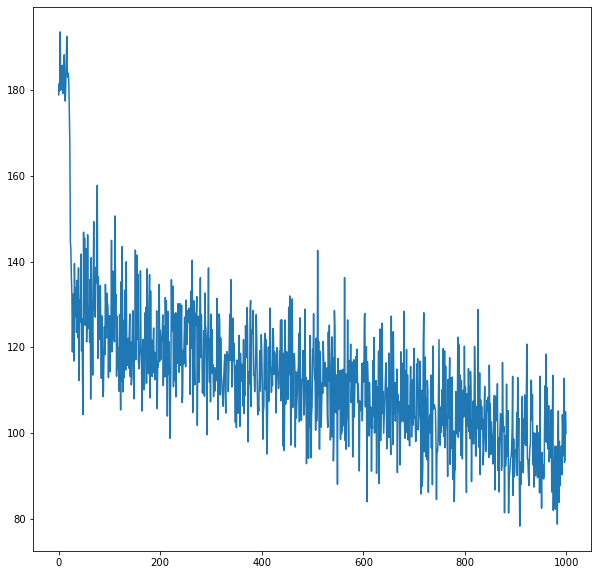

In [163]:
# Train it
net1 = ClassifierNN()
n_epochs = 1000
loss_fn = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = torch.optim.SGD(net1.parameters(), lr=0.0001, momentum=0.8)
for epoch in tqdm(range(n_epochs)):
    for X_batch, y_batch in train_dl:
        y_pred = net1(X_batch)
        torch.nan_to_num(y_pred)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    net1.losses.append(loss.item())
plt.figure(figsize=(10,10))
plt.plot(net1.losses);

y_pred = []
print(test_all)
with torch.no_grad():
    for X_batch, y_batch in test_all:
        y_pred = np.log(net1(X_batch))
submission_df = pd.DataFrame(y_pred, columns=class_mapping.values())
submission_df.columns = ['no answer', 'very important', 'quite important', 'not important', 'not at all important']
submission_df.insert(0, 'id', df_test.index)

# Save the submission file
# submission_file = 'submission.csv'
submission_file = 'submission2.xlsx'
## submission_df.to_csv(submission_file,lineterminator=None, index=False)
with pd.ExcelWriter(submission_file) as writer:
    submission_df.to_excel(writer, sheet_name="Sheet1") 
